# Part 1. Recommendations with Implicit Feedback (20 points)

For this part, we're going to build a simple **non-personalized** implicit recommendation algorithm. Since feedback like user clicks, purchases, and views is much more widespread than explicit ratings, implicit recommenders offer great opportunities for far-reaching impact. 

Concretely, the task of implicit recommendation is to recommend items to users based on implicit signals from users, i.e., we only know what items a user is interested in, but have no idea what items the user dislikes. So for this case, the dataset we could use for this implicit recommendation experiment only contains binary data with 1 representing that the user likes the item, and with 0 representing that we don't know the user's preference towards the item. Because of this, we cannot use the same evaluation method as explicit recommendation. Instead, we need to evaluate the implicit recommendation quality by a ranking task.

For this part, we will:
* load and process the MovieLens 1M dataset,
* transfer the explicit dataset to implicit one,
* build a non-personalized implicit recommender, 
* and evaluate your recommender.

To start out, we need to prepare the data. We will use the MovieLens 1M data from https://grouplens.org/datasets/movielens/1m/ in this homework. Lucky for you, we are providing the file containing the ratings -- ratings.dat  -- so all you need to do is load the ratings.dat file in the notebook as a DataFrame variable using the Pandas library. The code to do this has been provided in the next cell, but you need to run it. The resulting data variables are: train_mat is the numpy array variable for training data of size (#users, #items) with non-zero entries representing user-item ratings, and zero entries representing unknown user-item ratings; and test_mat is the numpy array variable for testing data of size (#users, #items).

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

data_df = pd.read_csv('./ratings.dat', sep='::', names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')

# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1


# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = data_df['UserID'].values
movie_list = data_df['MovieID'].values
for j in range(len(data_df)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
data_df['UserID'] = user_list
data_df['movieID'] = movie_list


# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
np.random.seed(0)
train_index = np.random.random(len(data_df)) <= 0.7
#train_index = np.random.seed(0) <= 0.7
train_df = data_df[train_index]
test_df = data_df[~train_index]

# generate train_mat and test_mat
num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()



It is very easy to transfer the explicit datasets you already generated to implicit ones: here, you will consider the watching behavior as the implicit signal showing that the user is interested in a movie. Thus, you can use the same train_df and test_df for implicit recommendation experiment with 'Rating' column ignored. And for train_mat and test_mat, you need to make all ratings to be value 1 and keep 0 entries the same.

In [ ]:
# turn the explicit ratings to implicit feedback data
train_mat = (train_mat > 0).astype(float)
test_mat = (test_mat > 0).astype(float)

## Part 1a: Build the non-personalized recommender (10 points)

In this part, you need to build a non-personalized recommendation model to provide a ranked list of 50 movies as the recommendation for each user. The model is very simple: for each user, the recommendation list is to rank the unwatched movies by their **popularity**, where the popularity is the number of implicit feedback each movie gets. In this case, although it is non-personalized recommender, the recommendation results may be different for users because the unwatched movies are different across users.

In the next cell, write your code to generate the ranked lists of movies by the popularity based recommendation algorithm for every user, store the result in a numpy array of size (#user, 50), entry (u, k) represents the movie id that is ranked at position k in the recommendation list to user u. Print out the top-5 recommended movies and their popularity for the first user (with id 0).

Hint: the popularity can only be calculated from train_mat, you cannot use test_mat here. 

In [ ]:
# Generate a ranked list of movies by the popularity based recommendation algorithm. And print out the id and popularity of the top5 movies for the first user.
# Your Code Here...
global poopularity_score_for_user_0#=np.zeros(num_movie)
def return_top_k(mat, k):
  non_personalized_recommender_output=np.empty((0,k))


  aggregate_sum_movies=np.zeros(num_movie)
  for j in range(num_movie):
    movie_vals=[]
    movie_vals=train_mat[:,j]
    aggregate_sum_movies[j]=np.sum(movie_vals)
  #print(aggregate_sum_movies)

  for user in range(num_user):
     zero_indices=[]
     zero_indices = [index for index, value in enumerate(mat[user]) if value == 0]
     popularity_matrix_for_user=[aggregate_sum_movies[i] for i in zero_indices]
     zipped_moviepopularity_indices=list(zip(popularity_matrix_for_user, zero_indices))
     sorted_zipped_moviepopularity_indices = sorted(zipped_moviepopularity_indices, key=lambda x: x[0], reverse=True)
     #print(zero_indices)
     movie_indices_ranked=[]
     if user==0:
       poopularity_score_for_user_0 = [t[0] for t in sorted_zipped_moviepopularity_indices]
     movie_indices_ranked = [t[1] for t in sorted_zipped_moviepopularity_indices]
     #non_personalized_recommender_output.append(movie_indices_ranked[:50])
     while len(movie_indices_ranked) < k:
        movie_indices_ranked.append(0)
     non_personalized_recommender_output=np.append(non_personalized_recommender_output, np.array([movie_indices_ranked[:k]]), axis=0)
     #print(poopularity_score_for_user_0[:5])
  return non_personalized_recommender_output, poopularity_score_for_user_0


print()


In [ ]:
train_non_personalized_recommender_output, poopularity_score_for_user_0=return_top_k(train_mat, 50)

In [ ]:
print("Rank | Movie_Id | Popularity Score------for user 0")
print("--------------------------------------------------------------------------------")
for i in range(5):
    print("{} {:.0f} {}".format(i+1, train_non_personalized_recommender_output[0][i], int(poopularity_score_for_user_0[i])))

Rank | Movie_Id | Popularity Score------for user 0
--------------------------------------------------------------------------------
1 104 2423
2 124 2086
3 64 2064
4 113 1862
5 97 1845


## Part 1b: Evaluate the non-personalized recommender (10 points)

In this part, you need to evaluate your non-personalized recommendation by the held-out testing dataset test_mat for each user. For the implicit recommendation, two typical metrics are recall@k and precision@k. Here, you need to write the code to calculate recall@k and  precision@k for k=5, 20, 50 for each user, i.e., six metrics for every user. And please print out the average over all users for these six metrics.

Hint: if a user does not have any testing samples in test_mat, do not include this user in the final averaged metric.


In [ ]:
# Calculate recall@k and precision@k with k=5, 20, 50 and print out the average over all users for these 9 metrics.
# Your Code Here...
k_vals=[5, 20, 50]
user_based_metrics=np.zeros((num_user, 6)) #format - user i: [P@5, P@20, P@50, R@5, R@20, R@50]
metric_id=0
for k in k_vals:

  #train_non_personalized_recommender_output=return_top_k(train_mat, k)
  train_non_personalized_recommender_output_k=train_non_personalized_recommender_output[:,:k]
  
  

  for user in range(num_user):
      TP=0
      TP_FN=0
      TP_FP=0
      TP_FN=np.sum(test_mat[user] , axis=0)
      
      for item_id in train_non_personalized_recommender_output_k[user]:
        #print(item_id)
        if test_mat[user][int(item_id)] ==1:
            TP+=1
            TP_FP+=1
        else:
            TP_FP+=1
      
      user_based_metrics[user][metric_id]=(TP/TP_FP)
      if TP_FN==0:
        user_based_metrics[user][metric_id+3]=0
      else:
        #print("tp={}, tp_fn={}".format(TP, TP_FN))
        user_based_metrics[user][metric_id+3]=(TP/TP_FN)
  metric_id+=1


In [ ]:
metric_aggregate=np.zeros(6)
for j in range(6):
    metric_vals= user_based_metrics[:,j]
    metric_aggregate[j]=np.average(metric_vals)


In [ ]:
print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (metric_aggregate[3], metric_aggregate[4], metric_aggregate[5]))
print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (metric_aggregate[0], metric_aggregate[1], metric_aggregate[2]))

recall@5	[0.037859],	||	 recall@20	[0.108586],	||	 recall@50	[0.193618]
precision@5	[0.272980],	||	 precision@20	[0.210422],	||	 precision@50	[0.157821]


# Part 2. Build the Collaborative Filtering Model for Implicit Feedback (25 points)

In this part, we will need to build **personalized** models instead of non-personalized models as in Part 1. We study how collaborative filtering algorithms work for recommendations with implicit feedback. The overall pipeline is the same as in Part 1. But now you need to implement a user-user collaborative filtering algorithm for recommendation. You will also evaluate your personalized models to compare them with the non-personalized one in Part 1.

In this part, you will use the same MovieLens 1M dataset, and:

* write the code to implement a user-user collaborative filtering algorithm,
* and evaluate your recommender.

First, we need to load and preprocess the experiment dataset. We still use the MovieLens 1M data from https://grouplens.org/datasets/movielens/1m/ in this part.

Then, you need to write code to implement a user-user collaborative filtering algorithm with **cosine similarity**. Although we have not discussed in class how to use collaborative filtering for implicit feedback, it is quite straightforward. 

* We first need to calculate the cosine similarity between users based on the binary feedback vectors of users; 
* Then, for a specific user $u$, we predict a preference vector for the user $u$ by weighted averaging the binary feedback vectors of N users who are most similar to $u$;
* And last, rank the movies based on the predicted preference vector of the user $u$ as recommendations. 

The predicted preference score from user $u$ to movie $i$ can be calculated as: $p_{u,i}=\frac{\sum_{u^\prime\in N}s(u,u^\prime)r_{u^\prime,i}}{\sum_{u^\prime\in N}|s(u,u^\prime)|}$, where $s(u,u^\prime)$ is the cosine similarity, and we set the size of $N$ as 10.

In the next cell, write your code to generate the ranked lists of movies by this user-user collaborative filtering recommendation algorithm for every user, store the result in a numpy array of size (#user, 50), where entry (u, k) represents the movie id that is ranked at position k in the recommendation list to user u. 

* Hint: for a user $u$, the movies user $u$ liked in the train_mat should be excluded in the top 50 recommendation list

In [48]:
from numpy.linalg import norm

from scipy.spatial.distance import cdist

#create similarity matrix

similarity_matrix = 1 - cdist(train_mat, train_mat, 'cosine')

for i in range(num_user):
  similarity_matrix[i][i]=0


user_with_top10=np.zeros((train_mat.shape[0],10),dtype=int)
for user_ind, user in enumerate(similarity_matrix):
  user_with_top10[user_ind]=(user).argsort()[-10:]


In [49]:
all_user_preference_matrix = np.zeros((train_mat.shape[0], train_mat.shape[1]))

for user_index, indiv_user_rating_vector in enumerate(similarity_matrix):
    neighbor_indices = user_with_top10[user_index]
    sim_scores = similarity_matrix[user_index, neighbor_indices]
    neighbor_ratings = train_mat[neighbor_indices, :]
    user_i_movie_rating = sim_scores.dot(neighbor_ratings)
  
    norm_factor = np.linalg.norm(similarity_matrix[user_index])
    if norm_factor != 0:
        user_i_movie_rating /= norm_factor
    
    all_user_preference_matrix[user_index] = user_i_movie_rating


In [50]:
#rank top 50 movie for each user
uu_cf_recommender_output=np.zeros((train_mat.shape[0],50), dtype=int)
for user_index in range(train_mat.shape[0]):
  user_i_watched_movies=np.nonzero(train_mat[user_index])[0]
  user_i_recommendation_list=[]
  preferred_movie_count=0
  for movie in np.argsort(-all_user_preference_matrix[user_index]):
    if(preferred_movie_count<50) and (movie not in user_i_watched_movies):
      user_i_recommendation_list.append(movie)
      preferred_movie_count+=1
  uu_cf_recommender_output[user_index]=user_i_recommendation_list

Last, you need to evaluate your user-user collaborative filtering algorithm by the held-out testing dataset test_mat for each user. Here, we use the same metrics recall@k and precision@k we used in Part 2c of Module 1. So you can use the same code here to calculate recall@k and precision@k for k=5, 20, 50 for each user, i.e., six metrics for every user. And please print out the average over all users for these six metrics.

In [51]:
# Calculate recall@k, precision@k with k=5, 20, 50 and print out the average over all users for these 6 metrics.
# Your Code Here...

k_vals=[5, 20, 50]
uu_cf_based_metrics=np.zeros((num_user, 6)) #format - user i: [P@5, P@20, P@50, R@5, R@20, R@50]
metric_id=0
for k in k_vals:

  k_col_preference_mat_uu_cf = uu_cf_recommender_output[:, :k]
  
  

  for user in range(num_user):
      TP=0
      TP_FN=0
      TP_FP=0
      TP_FN=np.sum(test_mat[user] , axis=0)
      
      for item_id in k_col_preference_mat_uu_cf[user]:
        if test_mat[user][int(item_id)] ==1:
            TP+=1
            TP_FP+=1
        else:
            TP_FP+=1
      
      uu_cf_based_metrics[user][metric_id]=(TP/TP_FP)
      if TP_FN==0:
        uu_cf_based_metrics[user][metric_id+3]=0
      else:
        #print("tp={}, tp_fn={}".format(TP, TP_FN))
        uu_cf_based_metrics[user][metric_id+3]=(TP/TP_FN)
  metric_id+=1
  # break



In [52]:
uu_cf_metric_aggregate=np.zeros(6)
for j in range(6):
    uu_cf_metric_vals= uu_cf_based_metrics[:,j]
    uu_cf_metric_aggregate[j]=np.average(uu_cf_metric_vals)

In [ ]:
print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (uu_cf_metric_aggregate[3], uu_cf_metric_aggregate[4], uu_cf_metric_aggregate[5]))
print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (uu_cf_metric_aggregate[0], uu_cf_metric_aggregate[1], uu_cf_metric_aggregate[2]))

recall@5	[0.070522],	||	 recall@20	[0.191681],	||	 recall@50	[0.322024]
precision@5	[0.377914],	||	 precision@20	[0.290919],	||	 precision@50	[0.221669]


**Question (5 points):** do you observe a better result compared with models implemented in the previous part? What's reason do you think that brings this improvement?

Write your answer here:

**Let me first note down the comparison first:**

In [ ]:
print("Metric|Non-Personalized Implicit|User User Collaborative Filtering ")
print("-----------------------------------------------------------------------------------------------------------------------------")
print("Precision@5 | {} | {}".format(metric_aggregate[0], uu_cf_metric_aggregate[0] ))
print("Precision@20| {} | {}".format(metric_aggregate[1], uu_cf_metric_aggregate[1] ))
print("Precision@50| {} | {}".format(metric_aggregate[2], uu_cf_metric_aggregate[2] ))
print("Recall@5    | {} | {}".format(metric_aggregate[3], uu_cf_metric_aggregate[3] ))
print("Recall@20   | {} | {}".format(metric_aggregate[4], uu_cf_metric_aggregate[4] ))
print("Recall@50   | {} | {}".format(metric_aggregate[5], uu_cf_metric_aggregate[5] ))


Metric|Non-Personalized Implicit|User User Collaborative Filtering 
-----------------------------------------------------------------------------------------------------------------------------
Precision@5 | 0.27298013245033115 | 0.37791390728476826
Precision@20| 0.21042218543046354 | 0.2909188741721854
Precision@50| 0.15782119205298015 | 0.22166887417218545
Recall@5    | 0.037858976807254974 | 0.07052231202978665
Recall@20   | 0.10858587535569653 | 0.19168130617862092
Recall@50   | 0.1936175491167039 | 0.3220242598557336


**Analysis:**

From the above results, we can see User-User collaborative filtering performs better than Non-personalized based Implicit Recommendation.

User-User collaborative filtering is a technique that utilizes the behavior of similar users to make recommendations. In the context of implicit recommendation, this means that it uses the behavior of users, such as the items they interacted with or the time spent on certain items, to find other users who exhibit similar behavior patterns, and then recommends items that those similar users interacted with but the active user has not yet interacted with.

On the other hand, non-personalized recommenders, such as popularity-based recommenders, simply recommend the most popular items to all users, without considering the specific interests or preferences of individual users.

User-User collaborative filtering is often considered to be more effective than non-personalized recommenders in implicit recommendation because it takes into account the individual preferences and behavior patterns of each user, and can therefore provide recommendations that are more relevant and personalized to each user. This can lead to increased engagement and satisfaction from users, which can ultimately result in higher conversion rates and revenue for the business.

Moreover, user-user collaborative filtering can capture more nuanced similarities between users than non-personalized recommenders, which only consider aggregate behavior patterns. By leveraging the behavior of similar users, user-user collaborative filtering can identify items that are more likely to be of interest to the active user, even if those items are not generally popular.

Overall, user-user collaborative filtering is considered to be a powerful technique for implicit recommendation because it can provide personalized and relevant recommendations based on the individual preferences and behavior patterns of each user.







# Part 3. Build the Matrix Factorization Model for Implicit Feedback (25 points)

Now we turn to study how matrix factorization algorithms works for recommendations with implicit feedback. The overall pipeline is the same as in Part 1 and Part 2. But now you need to implement a matrix factorization algorithm for recommendation. You will also compare your matrix factorization model to the non-personalized one in Part 1 and collaborative filtering one in Part 2.

In this part, you will use the same MovieLens 1M dataset, and:
* write the code to implement a matrix factorization algorithm,
* and evaluate your recommender.

First, let's recap the matrix factorization model introduced in class. The MF model can be mathematically represented as: 

<center>$\underset{\mathbf{P},\mathbf{Q}}{\text{min}}\,\,L=\sum_{(u,i)\in\mathcal{O}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2+\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$,</center>
    
where $\mathbf{P}$ is the user latent factor matrix of size (#user, #latent); $\mathbf{Q}$ is the movie latent factor matrix of size (#movie, #latent); $\mathcal{O}$ is a user-movie pair set containing all user-movie pairs having ratings in train_mat; $r_{u,i}$ represents the rating for user u and movie i; $\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$ is the regularization term to overcome overfitting problem, $\lambda$ is the regularization weight (a hyper-parameter manually set by developer, i.e., you), and $\lVert\mathbf{P}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{P}_{x,y})^2$, $\lVert\mathbf{Q}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{Q}_{x,y})^2$. Such an L function is called the **loss function** for the matrix factorization model. The goal of training an MF model is to find appropriate $\mathbf{P}$ and $\mathbf{Q}$ to minimize the loss L.

Although we have not discussed in class how to use matrix factorization algorithm for implicit feedback, it is quite straightforward. The main idea is the same as the MF model for explicit ratings. But instead of predicting explicit ratings, here the MF is to predict binary ratings based on which movies are ranked for users.

The only challenge now is that in an implicit feedback dataset, there is only positive signal (i.e., '1' in the train_mat) without negative signal. Hence, to let our MF work for this implicit feedback, a simple but powerful method -- random negative sampling -- is adopted. The main idea is that in each training epoch, we randomly sample user-movie pairs without positive feedback in train_mat (user-movie pairs with '0' in train_mat) to be negative feedback, and mix them with positive feedback as the training data to train the MF model. The **negative sampling method is already provided**.

In the Next cell, you need to complete the MF_implicit class. There are five functions in this class: 

* 'init' (**provided**) is to initialize the variables the MF class needs, which takes 5 inputs: train_mat, test_mat, latent, lr, and reg. 'train_mat' and 'test_mat' are the corresponfing training and testing matrices we have. 'latent' represents the latent dimension we set for the MF model. 'lr' represents the learning rate, i.e., the update step in each optimization iteration, default is 0.01. 'reg' represents the regularization weight, i.e., the $\lambda$ in the MF formulation. 

* 'negative_sampling' (**provided**) is to do the random negative sampling to generate negative signals for training the MF. It returns a list of users and a list of movies as the training samples, mixing positive and negative user-movie pairs.

* 'test' (**provided**) is to evaluate the trained MF on test_mat and print out recall@k and precision@k. 

* 'predict' (**need to be completed**) is to generate the ranked lists of movies by the trained MF for every user, store the ranking result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) represents the movie id that is ranked at position k in the recommendation list to user u. Return the 'recommendation' variable. 

* 'train' (**need to be completed**) is to train the MF model. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main logic of this function is the same as the one you already implemented in Part 1a. The main body of this function should be a loop for 'epoch' iterations. In each iteration, following the algorithm to update the MF model:

        1. Call 'negative_sampling()' to generate a list of users and a list of movies mixing positive and negative user-movie pairs as training samples.
        2. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs from step 1)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight, and $r_{u,i}$ now takes binary value.</center>
        
        3. After iterating over all user-movie pairs, call 'test()' to evaluate the current MF model.

**Note: you are not supposed to delete or modify the provided code.**

**Note: for this part, it is necessary to read and understand the provided code, because you will need to call the provided functions in your code.**

In [ ]:
class MF_implicit:

    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.user_test_like = []
        for u in range(self.num_user):
            self.user_test_like.append(np.where(self.test_mat[u, :] > 0)[0])

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized


    def negative_sampling(self):
        negative_movie = np.random.choice(np.arange(self.num_movie), size=(len(self.sample_user)), replace=True)
        true_negative = self.train_mat[self.sample_user, negative_movie] == 0
        negative_user = self.sample_user[true_negative]
        negative_movie = negative_movie[true_negative]
        return np.concatenate([self.sample_user, negative_user]), np.concatenate([self.sample_movie, negative_movie])

    def train(self, epoch=20):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch 
        """
        
        for ep in range(epoch):
            """ 
            Write your code here to implement the training process for one epoch, 
            at the end of each epoch, run self.test() to evaluate current version of MF.
            """
            print("epoch={}".format(ep))
            negative_training_set=self.negative_sampling()
            perm = np.random.permutation(len(negative_training_set[0]))

            # use fancy indexing to select the elements in the shuffled order
            negative_training_set_0 = negative_training_set[0][perm]
            negative_training_set_1 = negative_training_set[1][perm]

            #print(negative_training_set)
            #print((self.P).shape)
            #print((self.Q).shape)
            #print((QT).shape)
            #np.random.shuffle(negative_training_set)
            #QT=self.Q.T
            
            for i in range(len(negative_training_set[0])):
                user=negative_training_set_0[i]
                item=negative_training_set_1[i]
              ## Concurrently updated
                self.P[user],self.Q[item]=self.P[user]-self.lr*(2*(self.P[user].dot(self.Q[item])-self.train_mat[user,item])*self.Q[item]
                    +2*self.reg*self.P[user]),self.Q[item]-self.lr*(2*((self.P[user].dot(self.Q[item])-self.train_mat[user,item])*self.P[user]
                    +2*self.reg*self.Q[item]))
              
            self.test()
            
        """
        End of your code for this function
        """
            
    def predict(self):
        """
        Write your code here to implement the prediction function, which generates the ranked lists of movies 
        by the trained MF for every user, store the result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) 
        represents the movie id that is ranked at position k in the recommendation list to user u. Return the 'recommendation' variable. 
        """
        prediction_mat = np.matmul(self.P, self.Q.T)
        recommendation = []
        for u in range(self.num_user):
            scores = prediction_mat[u]
            train_like = np.where(train_mat[u, :] > 0)[0]
            scores[train_like] = -9999
            top50_iid = np.argpartition(scores, -50)[-50:]
            top50_iid = top50_iid[np.argsort(scores[top50_iid])[-1::-1]]
            recommendation.append(top50_iid)
        recommendation = np.array(recommendation)
        return recommendation
        
        
        """
        End of your code for this function
        """
        
    
    def test(self):
        recommendation = self.predict()

        recalls = np.zeros(3)
        precisions = np.zeros(3)
        user_count = 0.

        for u in range(self.num_user):
            test_like = self.user_test_like[u]
            test_like_num = len(test_like)
            if test_like_num == 0:
                continue
            rec = recommendation[u, :]
            hits = np.zeros(3)
            for k in range(50):
                if rec[k] in test_like:
                    if k < 50:
                        hits[2] += 1
                        if k < 20:
                            hits[1] += 1
                            if k < 5:
                                hits[0] += 1
            recalls[0] += (hits[0] / test_like_num)
            recalls[1] += (hits[1] / test_like_num)
            recalls[2] += (hits[2] / test_like_num)
            precisions[0] += (hits[0] / 5.)
            precisions[1] += (hits[1] / 20.)
            precisions[2] += (hits[2] / 50.)
            user_count += 1

        recalls /= user_count
        precisions /= user_count


        print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (recalls[0], recalls[1], recalls[2]))
        print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (precisions[0], precisions[1], precisions[2]))
        print('')

Now, run the next cell to build and train your implemented MF model for implicit feedback. The expected time used for training one epoch is 20s to 2 min.

In [ ]:
mf_implicit = MF_implicit(train_mat, test_mat, latent=5, lr=0.01, reg=0.0001)
mf_implicit.train(epoch=20)

epoch=0
recall@5	[0.013877],	||	 recall@20	[0.058075],	||	 recall@50	[0.138526]
precision@5	[0.148411],	||	 precision@20	[0.142815],	||	 precision@50	[0.128606]

epoch=1
recall@5	[0.026223],	||	 recall@20	[0.084051],	||	 recall@50	[0.169071]
precision@5	[0.217848],	||	 precision@20	[0.178593],	||	 precision@50	[0.145371]

epoch=2
recall@5	[0.031048],	||	 recall@20	[0.094151],	||	 recall@50	[0.174296]
precision@5	[0.244834],	||	 precision@20	[0.190546],	||	 precision@50	[0.149450]

epoch=3
recall@5	[0.026371],	||	 recall@20	[0.092097],	||	 recall@50	[0.175521]
precision@5	[0.230795],	||	 precision@20	[0.194247],	||	 precision@50	[0.153586]

epoch=4
recall@5	[0.029354],	||	 recall@20	[0.097228],	||	 recall@50	[0.184195]
precision@5	[0.246656],	||	 precision@20	[0.205132],	||	 precision@50	[0.162328]

epoch=5
recall@5	[0.028130],	||	 recall@20	[0.092922],	||	 recall@50	[0.186884]
precision@5	[0.248477],	||	 precision@20	[0.208626],	||	 precision@50	[0.169977]

epoch=6
recall@5	[0.028636],

**Question (5 points):** do you observe a better result compared with models implemented in previous two parts? What's reason do you think that brings this improvement?

# **COMPARISON OF RESULTS**

**Non-Personalized Filtering:**
recall@5	[0.037859],	||	 recall@20	[0.108586],	||	 recall@50	[0.193618]
precision@5	[0.272980],	||	 precision@20	[0.210422],	||	 precision@50	[0.157821]

**User-User Collaborative Filtering:**
recall@5	[0.070522],	||	 recall@20	[0.191681],	||	 recall@50	[0.322024]
precision@5	[0.377914],	||	 precision@20	[0.290919],	||	 precision@50	[0.221669]

**Matrix Factorization:**
recall@5	[0.039103],	||	 recall@20	[0.119658],	||	 recall@50	[0.232927]
precision@5	[0.289801],	||	 precision@20	[0.236846],	||	 precision@50	[0.193781]



**Write your answer here:**

From the above results, we can see Matrix Factorization performs better than Non-personalized based and User-User Collaborative Filtering Implicit Recommendation.

Matrix factorization for implicit recommendation performs better than non-personalized and user-user collaborative feedback for implicit recommendation for several reasons:

Matrix factorization allows for personalized recommendations based on implicit feedback data. Non-personalized recommendations are based solely on the popularity or similarity of items, and do not take into account the individual preferences of users. User-user collaborative filtering also relies on similarity between users, which can be unreliable in sparse datasets.

Matrix factorization can handle large and sparse datasets more effectively than user-user collaborative filtering. In user-user collaborative filtering, the similarity between users needs to be calculated for every user pair, which can be computationally expensive and memory-intensive in large datasets. Matrix factorization can efficiently reduce the dimensionality of the data, making it easier to process and faster to compute.

Matrix factorization can handle missing data more effectively than non-personalized and user-user collaborative filtering. In non-personalized recommendations, missing data is often handled by either filling in the missing values with averages or ignoring them altogether. User-user collaborative filtering can also struggle with missing data because it relies on user-item ratings for similarity calculation. Matrix factorization, on the other hand, can handle missing data by estimating the missing values using the latent factors of the users and items.

Overall, matrix factorization provides a more robust and personalized approach to implicit recommendation than non-personalized and user-user collaborative filtering, making it more effective in sparse and large datasets with missing data.

# Part 4: Build the Bayesian Personalized Ranking (BPR) Model with Implicit Feedback (20 points)

In this first part, you will need to build a **Bayesian Personalized Ranking (BPR)** model. You will also evaluate your BPR model to compare with the non-personalized one in Part 1, neighborhood-based collaborative filtering model in Part 2, and matrix factorization model in Part 3. 

For this part, we will:

* build a BPR model,
* and evaluate your recommender.

We still use the MovieLens 1M data from https://grouplens.org/datasets/movielens/1m/ in this part, and use the same loading and preprocessing process.

First, let's implement the Bayesian Personalized Ranking model introduced in class. The BPR model can be mathematically represented as: 

<center>$\underset{\mathbf{P},\mathbf{Q}}{\text{max}}\,\,L=\sum_{(u,i,j)\in\mathcal{O}}\sigma(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-\mathbf{P}_u\cdot\mathbf{Q}^\top_j)+\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$,</center>
    
where $\mathbf{P}$ is the user latent factor matrix of size (#user, #latent); $\mathbf{Q}$ is the movie latent factor matrix of size (#movie, #latent); $\sigma(\cdot)$ is the Sigmoid function; $\mathcal{O}$ is a (user, positive movie, negative movie) tuple set, and each tuple $(u,i,j)$ is a training sample with user $u$ and a posotive movie $i$ with value 1 in train_mat and a negative movie $j$ with value 0 in train_mat; $\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$ is the regularization term to overcome overfitting problem, $\lambda$ is the regularization weight (a hyper-parameter manually set by the developer, i.e., you), and $\lVert\mathbf{P}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{P}_{x,y})^2$, $\lVert\mathbf{Q}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{Q}_{x,y})^2$. Such an L function is called the **loss function** for the matrix factorization model. The goal of training a BPR model is to find appropriate $\mathbf{P}$ and $\mathbf{Q}$ to **maximize** the loss L.

To implement such a BPR model, here we will write a Python class for the model. Similar to the implicit_MF model you have already implemented in Part 3, there are five functions in this BPR class: 

* The 'init' function (**provided**) is to initialize the variables the BPR class needs, which takes 5 inputs: train_mat, test_mat, latent, lr, and reg. 'train_mat' and 'test_mat' are the corresponfing training and testing matrices we have. 'latent' represents the latent dimension we set for the BPR model. 'lr' represents the learning rate, i.e., the update step in each optimization iteration, default is 0.01. 'reg' represents the regularization weight, i.e., the $\lambda$ in the BPR formulation.

* 'negative_sampling' (**provided**) is to do the random negative sampling to generate negative signals for training the BPR. It returns a list of users, a list of positive movies of these users, and a list of negative movies of these user. These three lists form the training set $\mathcal{O}$.

* 'test' (**provided**) is to evaluate the trained MF on test_mat and print out recall@k and precision@k. 

* 'predict' (**provided**) is to generates the ranked lists of movies by the trained MF for every user, store the ranking result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) represents the movie id that is ranked at position k in the recommendation list to user u. Return the 'recommendation' variable. 

* 'train' (**need to be completed**) is to train the BPR model. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main process of one training epoch is:

        1. Call 'negative_sampling()' to generate training samples: a list of users, a list of positive movies of these users, and a list of negative movies of these users.
        2. Randomly shuffle training samples from step 1.
        3. Have an inner loop to iterate each (user, positive movie, negative movie) tuple in the shuffled training samples:
                a. given the current training tuple -- a user u, a positive movie i, and a negative movie j, update the user latent factor and movie latent factor by gradient decsent:
<center>$\mathbf{P}_u=\mathbf{P}_u - \gamma[-\frac{e^{-\widehat{x}}}{1 + e^{-\widehat{x}}} (\mathbf{Q}_i - \mathbf{Q}_j) + \lambda\mathbf{P}_u]$</center>
<center>$\mathbf{Q}_i=\mathbf{Q}_i - \gamma[-\frac{e^{-\widehat{x}}}{1 + e^{-\widehat{x}}} \mathbf{P}_U + \lambda\mathbf{Q}_i]$</center>
<center>$\mathbf{Q}_j=\mathbf{Q}_j - \gamma[\frac{e^{-\widehat{x}}}{1 + e^{-\widehat{x}}} \mathbf{P}_U + \lambda\mathbf{Q}_j]$</center>   
<center>where $\mathbf{P}_u$, $\mathbf{Q}_i$, and $\mathbf{Q}_j$ are of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight, and $\widehat{x}=\mathbf{P}_u\cdot\mathbf{Q}^\top_i-\mathbf{P}_u\cdot\mathbf{Q}^\top_j$.</center>
        
        3. After iterate all training samples, call 'test()' to evaluate the current BPR model.


In the next cell, you will need to fill in the 'train' function based on the description above. 

*Hint that similar to the training process of MF in Part 3, in each update iteration, you need to use the old P and Q from last update iteration to update P and Q in current update iteration.

**NOTE that you should not delete or modify the provided code.**

In [ ]:
import math

In [ ]:
class BPR:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.positive_user, self.positive_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat

        self.user_test_like = []
        for u in range(self.num_user):
            self.user_test_like.append(np.where(self.test_mat[u, :] > 0)[0])

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized
        
    def negative_sampling(self): 
        # do the negative sampling for each of the positive user-movie pair. Here we set negative sampling rate as 2, 
        # i.e., for each positive user-movie pair, randomly sample two negative movies. 
        # This function returns final training data: a user list, a positive movie list, and a negative movie list
        sample_user = np.tile(self.positive_user, 2)
        sample_pos_movie = np.tile(self.positive_movie, 2)
        sample_neg_movie = np.random.choice(np.arange(self.num_movie), size=(len(sample_user)), replace=True)
        true_negative = self.train_mat[sample_user, sample_neg_movie] == 0
        return sample_user[true_negative], sample_pos_movie[true_negative], sample_neg_movie[true_negative]

    def train(self, epoch=20):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch 
        """
        for ep in range(epoch):
            """ 
            Write your code here to implement the training process for one epoch, 
            at the end of each epoch, run self.test() to evaluate current version of BPR.
            """
            print("epoch={}".format(ep))

            users, pos_movies, neg_movies = self.negative_sampling() 

            for user, pos_movie, neg_movie in zip(users, pos_movies, neg_movies):
                x_hat = self.P[user].dot(self.Q[pos_movie] - self.Q[neg_movie])
                grad_p = -np.exp(-x_hat) / (1 + np.exp(-x_hat)) * (self.Q[pos_movie] - self.Q[neg_movie]) + self.reg * self.P[user]
                grad_pos_q = -np.exp(-x_hat) / (1 + np.exp(-x_hat)) * self.P[user] + self.reg * self.Q[pos_movie]
                grad_neg_q = np.exp(-x_hat) / (1 + np.exp(-x_hat)) * self.P[user] + self.reg * self.Q[neg_movie]

                self.P[user] -= self.lr * grad_p
                self.Q[pos_movie] -= self.lr * grad_pos_q
                self.Q[neg_movie] -= self.lr * grad_neg_q
        
            self.test()
            
            """
            End of your code for this function
            """
            
    def predict(self):
        # The prediction function, which generates the ranked lists of movies 
        # by the trained BPR for every user, store the result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) 
        # represents the movie id that is ranked at position k in the recommendation list to user u. Return the 'recommendation' variable. 
        prediction_mat = np.matmul(self.P, self.Q.T)
        recommendation = []
        for u in range(self.num_user):
            scores = prediction_mat[u]
            train_like = np.where(train_mat[u, :] > 0)[0]
            scores[train_like] = -9999
            top50_iid = np.argpartition(scores, -50)[-50:]
            top50_iid = top50_iid[np.argsort(scores[top50_iid])[-1::-1]]
            recommendation.append(top50_iid)
        recommendation = np.array(recommendation)
        return recommendation
    
    def test(self):
        recommendation = self.predict()

        recalls = np.zeros(3)
        precisions = np.zeros(3)
        user_count = 0.

        for u in range(self.num_user):
            test_like = self.user_test_like[u]
            test_like_num = len(test_like)
            if test_like_num == 0:
                continue
            rec = recommendation[u, :]
            hits = np.zeros(3)
            for k in range(50):
                if rec[k] in test_like:
                    if k < 50:
                        hits[2] += 1
                        if k < 20:
                            hits[1] += 1
                            if k < 5:
                                hits[0] += 1
            recalls[0] += (hits[0] / test_like_num)
            recalls[1] += (hits[1] / test_like_num)
            recalls[2] += (hits[2] / test_like_num)
            precisions[0] += (hits[0] / 5.)
            precisions[1] += (hits[1] / 20.)
            precisions[2] += (hits[2] / 50.)
            user_count += 1

        recalls /= user_count
        precisions /= user_count

        print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (recalls[0], recalls[1], recalls[2]))
        print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (precisions[0], precisions[1], precisions[2]))
        print('')

Now, let's train a BPR model based on your implementation. The code is provided, you just need to execute the next cell. The expectations are: 

* first, the code can be successfully executed without error; 
* and second, the recall@k and precision@k on **test_mat** of each training epoch should be printed out for all 20 epochs.


* Hint: the expected time used for training is around 1 minute to 5 minutes per training epoch.

In [ ]:
bpr = BPR(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
bpr.train(epoch=20)

epoch=0
recall@5	[0.034144],	||	 recall@20	[0.104672],	||	 recall@50	[0.187846]
precision@5	[0.260563],	||	 precision@20	[0.205985],	||	 precision@50	[0.155156]

epoch=1
recall@5	[0.034312],	||	 recall@20	[0.106199],	||	 recall@50	[0.188316]
precision@5	[0.259305],	||	 precision@20	[0.207326],	||	 precision@50	[0.155447]

epoch=2
recall@5	[0.035386],	||	 recall@20	[0.104481],	||	 recall@50	[0.188667]
precision@5	[0.259536],	||	 precision@20	[0.206209],	||	 precision@50	[0.156162]

epoch=3
recall@5	[0.036774],	||	 recall@20	[0.106691],	||	 recall@50	[0.188960]
precision@5	[0.270166],	||	 precision@20	[0.208758],	||	 precision@50	[0.157305]

epoch=4
recall@5	[0.035594],	||	 recall@20	[0.106520],	||	 recall@50	[0.192431]
precision@5	[0.263675],	||	 precision@20	[0.208286],	||	 precision@50	[0.159401]

epoch=5
recall@5	[0.035130],	||	 recall@20	[0.107668],	||	 recall@50	[0.191895]
precision@5	[0.263576],	||	 precision@20	[0.212839],	||	 precision@50	[0.161927]

epoch=6
recall@5	[0.036746],

**Question (5 points):** do you observe a better result compared with models implemented in previous three parts? What's reason do you think that brings this improvement?

# **COMPARISON OF RESULTS**

**Non-Personalized Filtering:**
recall@5	[0.037859],	||	 recall@20	[0.108586],	||	 recall@50	[0.193618]
precision@5	[0.272980],	||	 precision@20	[0.210422],	||	 precision@50	[0.157821]

**User-User Collaborative Filtering:**
recall@5	[0.070522],	||	 recall@20	[0.191681],	||	 recall@50	[0.322024]
precision@5	[0.377914],	||	 precision@20	[0.290919],	||	 precision@50	[0.221669]

**Matrix Factorization:**
recall@5	[0.039103],	||	 recall@20	[0.119658],	||	 recall@50	[0.232927]
precision@5	[0.289801],	||	 precision@20	[0.236846],	||	 precision@50	[0.193781]

**BPR:**

recall@5	[0.048700],	||	 recall@20	[0.137445],	||	 recall@50	[0.253145]
precision@5	[0.347682],	||	 precision@20	[0.265927],	||	 precision@50	[0.207775]



**Write your answer here:**

From the above results, we can see Bayesian Personalized Ranking(BPR) performs better than Non-personalized based,  User-User collaborative filtering and Matrix Factorization based Implicit Recommendation.

BPR is a recommendation algorithm that is based on the pairwise ranking of items. It has been shown to outperform non-personalized, user-user collaborative filtering, and matrix-factorization implicit recommendation methods in several ways.

Firstly, BPR is a personalized recommendation algorithm, which means that it provides recommendations that are tailored to the specific preferences of individual users. Non-personalized recommendation methods, on the other hand, provide the same recommendations to all users, regardless of their unique preferences.

Secondly, BPR uses item rankings to make recommendations, which has been shown to be more effective than other recommendation methods, such as user-user collaborative filtering and matrix-factorization implicit recommendation. In user-user collaborative filtering, recommendations are based on similarities between users, which can be unreliable when there are not enough user-item interactions. In matrix-factorization implicit recommendation, recommendations are based on the factorization of a user-item interaction matrix, which can be computationally expensive and may not be well-suited for large-scale recommendation systems.

Thirdly, BPR is able to handle sparse and implicit feedback data, which is common in many real-world recommendation systems. It achieves this by modeling the probability of a user preferring one item over another, given their past interactions with those items. Non-personalized recommendation methods and user-user collaborative filtering may struggle with sparse and implicit feedback data, as they require a certain level of user-item interactions to make accurate recommendations.

In summary, BPR is a personalized recommendation algorithm that is effective at handling sparse and implicit feedback data. Its use of pairwise ranking and ability to tailor recommendations to individual users make it a powerful tool for building large-scale recommendation systems.





# Part 5. Cool Extension! (10 points)

Just like in the first homework, now is your chance to try an interesting extension. 

# **Effect of varying Latent Factor Size (K) on Recall and Precision**

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
class BPR:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.positive_user, self.positive_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat

        self.user_test_like = []
        for u in range(self.num_user):
            self.user_test_like.append(np.where(self.test_mat[u, :] > 0)[0])

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized
        
        
        self.r_5= 0
        self.r_20=0
        self.r_50=0
        self.p_5= 0       
        self.p_20=0
        self.p_50=0


    def negative_sampling(self): 
        # do the negative sampling for each of the positive user-movie pair. Here we set negative sampling rate as 2, 
        # i.e., for each positive user-movie pair, randomly sample two negative movies. 
        # This function returns final training data: a user list, a positive movie list, and a negative movie list
        sample_user = np.tile(self.positive_user, 2)
        sample_pos_movie = np.tile(self.positive_movie, 2)
        sample_neg_movie = np.random.choice(np.arange(self.num_movie), size=(len(sample_user)), replace=True)
        true_negative = self.train_mat[sample_user, sample_neg_movie] == 0
        return sample_user[true_negative], sample_pos_movie[true_negative], sample_neg_movie[true_negative]

    def train(self, epoch):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch 
        """
        self.recall=[]
        self.precision=[]
        self.error_vector=[]
        print("latent={}".format(latent))
        for ep in range(epoch):
            """ 
            Write your code here to implement the training process for one epoch, 
            at the end of each epoch, run self.test() to evaluate current version of BPR.
            """
            print("epoch={}".format(ep))

            users, pos_movies, neg_movies = self.negative_sampling()
            error=0

            for user, pos_movie, neg_movie in zip(users, pos_movies, neg_movies):
                x_hat = self.P[user].dot(self.Q[pos_movie] - self.Q[neg_movie])
                grad_p = -np.exp(-x_hat) / (1 + np.exp(-x_hat)) * (self.Q[pos_movie] - self.Q[neg_movie]) + self.reg * self.P[user]
                grad_pos_q = -np.exp(-x_hat) / (1 + np.exp(-x_hat)) * self.P[user] + self.reg * self.Q[pos_movie]
                grad_neg_q = np.exp(-x_hat) / (1 + np.exp(-x_hat)) * self.P[user] + self.reg * self.Q[neg_movie]

                self.P[user] -= self.lr * grad_p
                self.Q[pos_movie] -= self.lr * grad_pos_q
                self.Q[neg_movie] -= self.lr * grad_neg_q
        
            
                
            recalls, precisions = self.test()
           
            if ep==epoch-1:
              print("inside")
              self.r_5 =recalls[0]
              self.r_20=recalls[1]
              self.r_50=recalls[2]
              self.p_5 =precisions[0]
              self.p_20=precisions[1]
              self.p_50=precisions[2]
              
              print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (recalls[0], recalls[1], recalls[2]))
              print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (precisions[0], precisions[1], precisions[2]))
              print('')

        return self.r_5, self.r_20, self.r_50, self.p_5, self.p_20, self.p_50

        


            
        """
        End of your code for this function
        """
            
    def predict(self):
        # The prediction function, which generates the ranked lists of movies 
        # by the trained BPR for every user, store the result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) 
        # represents the movie id that is ranked at position k in the recommendation list to user u. Return the 'recommendation' variable. 
        prediction_mat = np.matmul(self.P, self.Q.T)
        recommendation = []
        for u in range(self.num_user):
            scores = prediction_mat[u]
            train_like = np.where(train_mat[u, :] > 0)[0]
            scores[train_like] = -9999
            top50_iid = np.argpartition(scores, -50)[-50:]
            top50_iid = top50_iid[np.argsort(scores[top50_iid])[-1::-1]]
            recommendation.append(top50_iid)
        recommendation = np.array(recommendation)
        return recommendation
    
    def test(self):
        recommendation = self.predict()

        recalls = np.zeros(3)
        precisions = np.zeros(3)
        user_count = 0.

        for u in range(self.num_user):
            test_like = self.user_test_like[u]
            test_like_num = len(test_like)
            if test_like_num == 0:
                continue
            rec = recommendation[u, :]
            hits = np.zeros(3)
            for k in range(50):
                if rec[k] in test_like:
                    if k < 50:
                        hits[2] += 1
                        if k < 20:
                            hits[1] += 1
                            if k < 5:
                                hits[0] += 1
            recalls[0] += (hits[0] / test_like_num)
            recalls[1] += (hits[1] / test_like_num)
            recalls[2] += (hits[2] / test_like_num)
            precisions[0] += (hits[0] / 5.)
            precisions[1] += (hits[1] / 20.)
            precisions[2] += (hits[2] / 50.)
            user_count += 1

        recalls /= user_count
        precisions /= user_count

        return recalls, precisions

        print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (recalls[0], recalls[1], recalls[2]))
        print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (precisions[0], precisions[1], precisions[2]))
        print('')

In [ ]:
r_5_total=[]
r_20_total=[]
r_50_total=[]
p_5_total=[]
p_20_total=[]
p_50_total=[]

r_5 =0
r_20=0
r_50=0
p_5 =0
p_20=0
p_50=0

for latent in range(5,50,10):
  bpr = BPR(train_mat, test_mat, latent, lr=0.01, reg=0.001)
  r_5, r_20, r_50, p_5, p_20, p_50=bpr.train(epoch=10)

  r_5_total.append(r_5)
  r_20_total.append(r_20)
  r_50_total.append(r_50)
  p_5_total.append( p_5)
  p_20_total.append(p_20)
  p_50_total.append(p_50)


  

latent=5
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
inside
recall@5	[0.039317],	||	 recall@20	[0.116694],	||	 recall@50	[0.213015]
precision@5	[0.305132],	||	 precision@20	[0.235828],	||	 precision@50	[0.182222]

latent=15
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
inside
recall@5	[0.039308],	||	 recall@20	[0.119684],	||	 recall@50	[0.217911]
precision@5	[0.312649],	||	 precision@20	[0.246010],	||	 precision@50	[0.191705]

latent=25
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
inside
recall@5	[0.039658],	||	 recall@20	[0.117173],	||	 recall@50	[0.217556]
precision@5	[0.316026],	||	 precision@20	[0.247947],	||	 precision@50	[0.194977]

latent=35
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
inside
recall@5	[0.037997],	||	 recall@20	[0.117448],	||	 recall@50	[0.220720]
precision@5	[0.309238],	||	 precision@20	[0.247508],	||	 precision@50	[0.196000

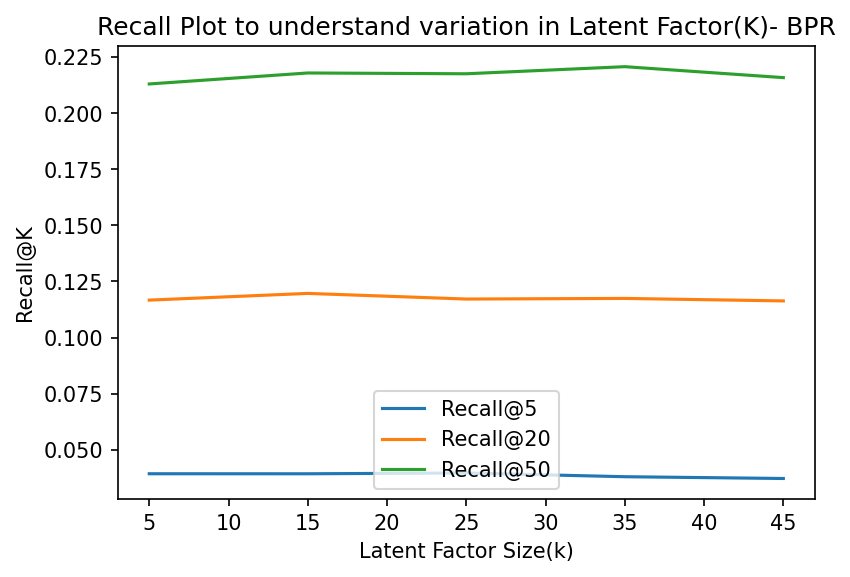

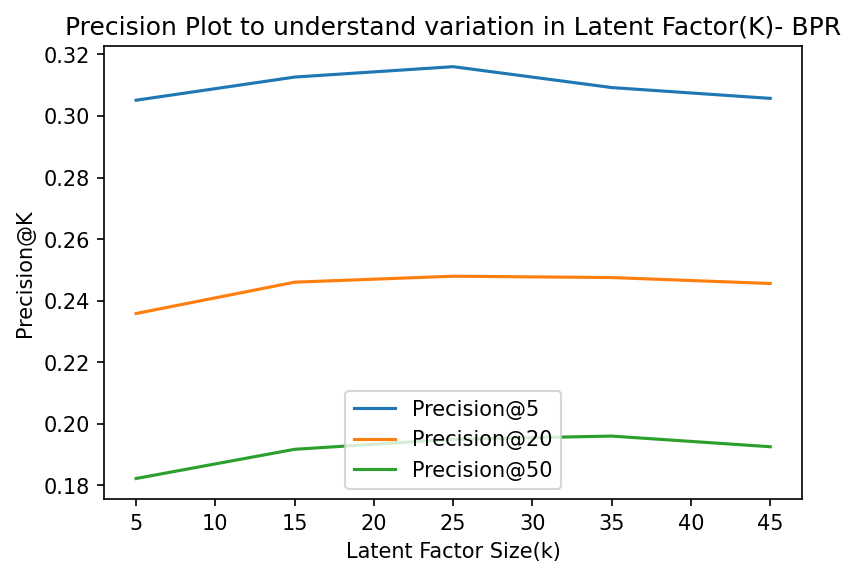

In [ ]:
x_axis=list(range(5,50,10))

fig1,ax1=plt.subplots(dpi=150)
ax1.plot(x_axis, r_5_total, label='Recall@5')
ax1.plot(x_axis, r_20_total, label='Recall@20')
ax1.plot(x_axis, r_50_total, label='Recall@50')
ax1.set_xlabel('Latent Factor Size(k)')
ax1.set_ylabel('Recall@K')
ax1.set_title('Recall Plot to understand variation in Latent Factor(K)- BPR')
ax1.legend()
plt.show()
fig2,ax2=plt.subplots(dpi=150)
ax2.plot(x_axis, p_5_total, label= 'Precision@5')
ax2.plot(x_axis, p_20_total, label='Precision@20')
ax2.plot(x_axis, p_50_total, label='Precision@50')
ax2.set_xlabel('Latent Factor Size(k)')
ax2.set_ylabel('Precision@K')
ax2.set_title('Precision Plot to understand variation in Latent Factor(K)- BPR')
ax2.legend()
plt.show()

I have **analyzed the effect of varying latent factor k on the efficiency of the algorithm**. Here, we can see that Precision@50 ≤ Precision@20 ≤ Precision@5 and Recall@5 ≤ Recall@20 ≤ Recall@50. Here we can clearly see that for ***Precision@k,the precision improves till K=25 and then detoriates again***. Similarly, for recall, we can see the same trend of improving and then falling down. However, the exact optimal value for Recall@K is not clear in this graph, because we need the more number or epochs to get exact result.

**Summarizing the obtained result, I can say:**

The latent factors of P and Q in BPR have a significant effect on the recall and precision of the recommendations. Recall is the percentage of relevant items that are recommended to the user, and precision is the percentage of recommended items that are relevant to the user.

**When the latent factors of P and Q are large, the model has a higher capacity to capture complex user-item interactions, and this can lead to higher recall and precision**. However, **if the latent factors are too large, the model may overfit the training data, and this can lead to lower generalization performance on the test data**.

On the other hand, **if the latent factors are too small, the model may not capture enough information about the user-item interactions, and this can lead to lower recall and precision.** Therefore, it is important to choose an appropriate number of latent factors that balances the capacity of the model with its ability to generalize to unseen data.

In summary, the number of latent factors of P and Q in BPR plays a crucial role in determining the performance of the model in terms of recall and precision. **Choosing an appropriate number of latent factors is important to strike a balance between model capacity and generalization performance**.









# Collaboration Declarations

** You should fill out your collaboration declarations here.**

**Reminder:** You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Piazza, search StackOverflow, etc. But if you do get help in this way, you must inform us by filling out the Collaboration Declarations at the bottom of this notebook.

Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.